<img src="imgs/GeorgiaTech_RGB.png" alt="GeorgiaTech_RGB" width="200"/>

# <span style='color:#B3A369'> <b>Analyze Battery Data</b> </span>

> <b> Notebook Author:</b> Brian Keith (bkeith9@gatech.edu) <br>
> 
> **Data Citation:**
> - Severson et al. Data-driven prediction of battery cycle life before capacity degradation. Nature Energy volume 4, pages 383–391 (2019)
> - Downloaded from: https://data.matr.io/1/projects/5c48dd2bc625d700019f3204
>   - Batch 1 (`2017-05-12_batchdata_updated_struct_errorcorrect.mat`): https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86c0b5fa2ede00015ddf67
>   - Batch 2 (`2017-06-30_batchdata_updated_struct_errorcorrect.mat`): https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86bf14fa2ede00015ddd83
>   - Batch 3 (`2018-04-12_batchdata_updated_struct_errorcorrect.mat`): https://data.matr.io/1/projects/5c48dd2bc625d700019f3204/batches/5c86bd64fa2ede00015ddbb3


# <span style='color:#B3A369'> Initial Tasks </span>

## <span style='color:#003057'> Load Necessary Libraries </span>

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

import pymc as pm
from pymc.math import exp, switch, ge, dot
import arviz as az
print(pm.__version__)

import warnings
#ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

from IPython.display import display, Markdown
def printmd(string):
    header_map = {1:'#B3A369',2:'#003057',3:'#54585A'}
    if string.startswith('#'):
        nh = string.count('#')
        string = string.replace('#','')
        display(Markdown('#'*nh + f' <span style="color:{header_map[nh]}">{string}</span>'))
    else:
        display(Markdown(string))

def render_mpl_table(data, col_width=3.0, row_height=0.4, font_size=10,
                     header_color='#202F65', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    #function modified from https://stackoverflow.com/a/39358722
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    # Include the index in the table
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         rowLabels=data.index, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items(): 
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] == -1:  # The index will be at position -1
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax

#check if directory 'figs' exists, if not create it
#Code will run without this, but the rendered markdown may have broken links in the source code file
if not pathlib.Path('figs').exists():
    pathlib.Path('figs').mkdir()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


5.10.0


## <span style='color:#003057'> Load Data </span>

In [2]:
DATA_DIR = 'data/'

summary_file = 'SummaryData.pkl'
cm_file = 'CycleMeasuredData.pkl'
cd_file = 'CycleDerivedData.pkl'

sum_raw = pd.read_pickle(DATA_DIR + summary_file)
printmd('## Summary Data')
display(sum_raw)
sum_raw.info()

#? do not need to read in detailed cycle data anymore, not used in this notebook
# cm_raw = pd.read_pickle(DATA_DIR + cm_file)
# cd_raw = pd.read_pickle(DATA_DIR + cd_file)

# printmd('## Cycle Measured Data')
# display(cm_raw)
# cm_raw.info()

# printmd('## Cycle Derived Data')
# display(cd_raw)
# cd_raw.info()

#! delete columns that are never used in the analysis
# just makes things easier to show in my report
del_cols = ['IR', 'QC', 'Tavg', 'Tmin', 'Tmax', 'chargetime']
print(f'Deleting columns: {del_cols}')
sum_raw.drop(columns=del_cols, inplace=True)
printmd('## Summary Data (after deleting columns)')
display(sum_raw)


## <span style="color:#003057"> Summary Data</span>

,batch,charge_policy,cycle_life,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle
0,b1c0,3.6C(80%)-3.6C,1852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,b1c0,3.6C(80%)-3.6C,1852,0.016742,1.071042,1.070689,31.875011,29.566130,35.652016,13.341250,2
2,b1c0,3.6C(80%)-3.6C,1852,0.016724,1.071674,1.071900,31.931490,29.604385,35.692978,13.425777,3
3,b1c0,3.6C(80%)-3.6C,1852,0.016681,1.072304,1.072510,31.932603,29.744202,35.680588,13.425167,4
4,b1c0,3.6C(80%)-3.6C,1852,0.016662,1.072970,1.073174,31.959322,29.644709,35.728691,13.341442,5
...,...,...,...,...,...,...,...,...,...,...,...
100496,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.017538,0.881796,0.881539,32.532753,30.328932,34.571934,15.404138,1796
100497,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.017294,0.881874,0.881441,32.679857,29.591684,35.492989,15.497987,1797
100498,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.017605,0.881364,0.880883,32.217071,31.470758,33.999550,16.357937,1798
100499,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.017526,0.881120,0.880757,33.035630,29.526152,35.779078,16.046140,1799


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100501 entries, 0 to 100500
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   batch          100501 non-null  category
 1   charge_policy  100501 non-null  category
 2   cycle_life     100501 non-null  int16   
 3   IR             100501 non-null  float64 
 4   QC             100501 non-null  float64 
 5   QD             100501 non-null  float64 
 6   Tavg           100501 non-null  float64 
 7   Tmin           100501 non-null  float64 
 8   Tmax           100501 non-null  float64 
 9   chargetime     100501 non-null  float64 
 10  cycle          100501 non-null  int16   
dtypes: category(2), float64(7), int16(2)
memory usage: 5.9 MB
Deleting columns: ['IR', 'QC', 'Tavg', 'Tmin', 'Tmax', 'chargetime']


## <span style="color:#003057"> Summary Data (after deleting columns)</span>

,batch,charge_policy,cycle_life,QD,cycle
0,b1c0,3.6C(80%)-3.6C,1852,0.000000,1
1,b1c0,3.6C(80%)-3.6C,1852,1.070689,2
2,b1c0,3.6C(80%)-3.6C,1852,1.071900,3
3,b1c0,3.6C(80%)-3.6C,1852,1.072510,4
4,b1c0,3.6C(80%)-3.6C,1852,1.073174,5
...,...,...,...,...,...
100496,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.881539,1796
100497,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.881441,1797
100498,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.880883,1798
100499,b3c45,4.8C(80%)-4.8C-newstructure,1801,0.880757,1799


# <span style='color:#B3A369'> Initial Investigation </span>

## <span style='color:#003057'> Visualize Discharge Capacity over Cycles </span>

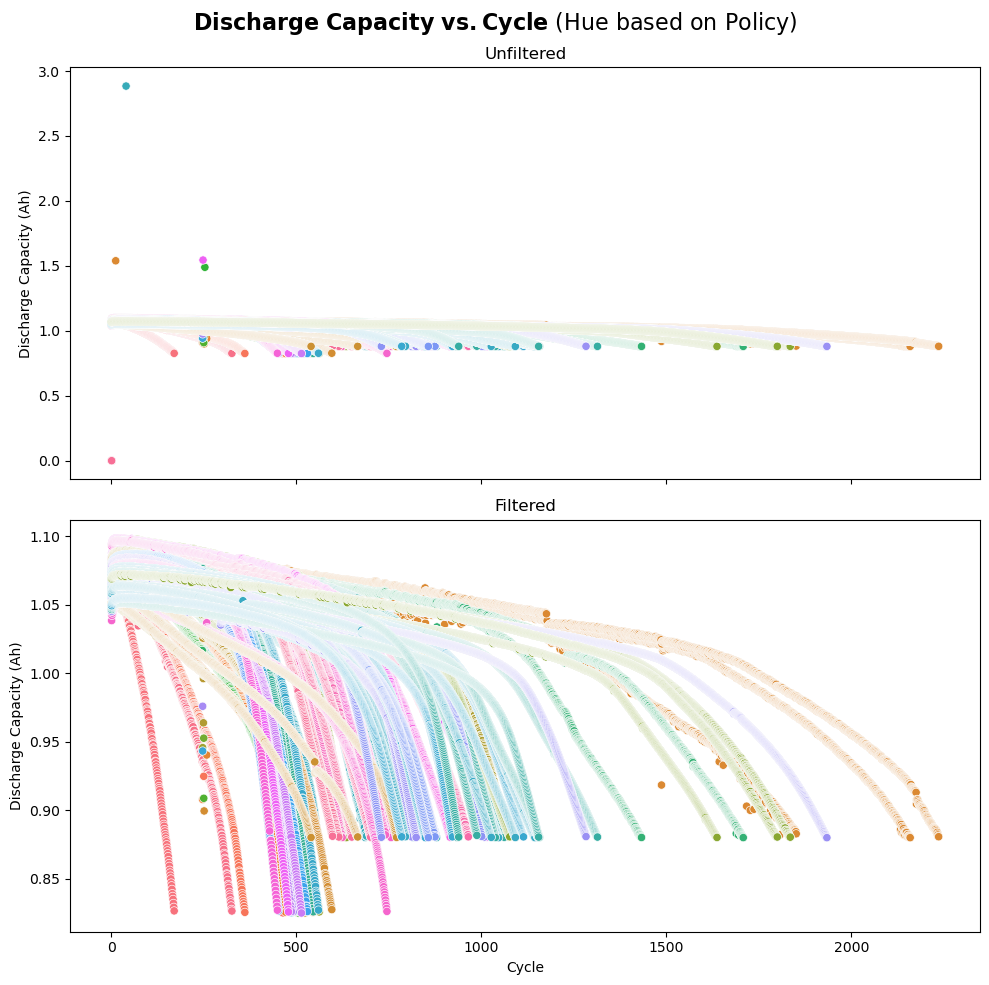

In [3]:
vis_qd = sum_raw[['cycle','QD','charge_policy']]
vis_qd_filt = vis_qd[(vis_qd.QD < 1.4) & (vis_qd.QD > 0.6)]

fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex=True)
sns.scatterplot(x='cycle', y='QD', hue='charge_policy', data=vis_qd, ax=ax[0])
sns.scatterplot(x='cycle', y='QD', hue='charge_policy', data=vis_qd_filt, ax=ax[1])

ax[0].set_title('Unfiltered')
ax[0].set_ylabel('Discharge Capacity (Ah)')
ax[0].legend_.remove()

ax[1].set_title('Filtered')
ax[1].set_xlabel('Cycle')
ax[1].set_ylabel('Discharge Capacity (Ah)')
ax[1].legend_.remove()

plt.suptitle(r'$\bf{Discharge\ Capacity\ vs. Cycle}$ (Hue based on Policy)', fontsize=16)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/RawCapacity.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()


## <span style='color:#003057'> Visualize Outliers </span>

> After seeing the abox plot, it is clear that there are some clear outliers in the data which will need to be removed (i.e., the zeros). The box plot below show the distributions before and afeter removing the outliers.

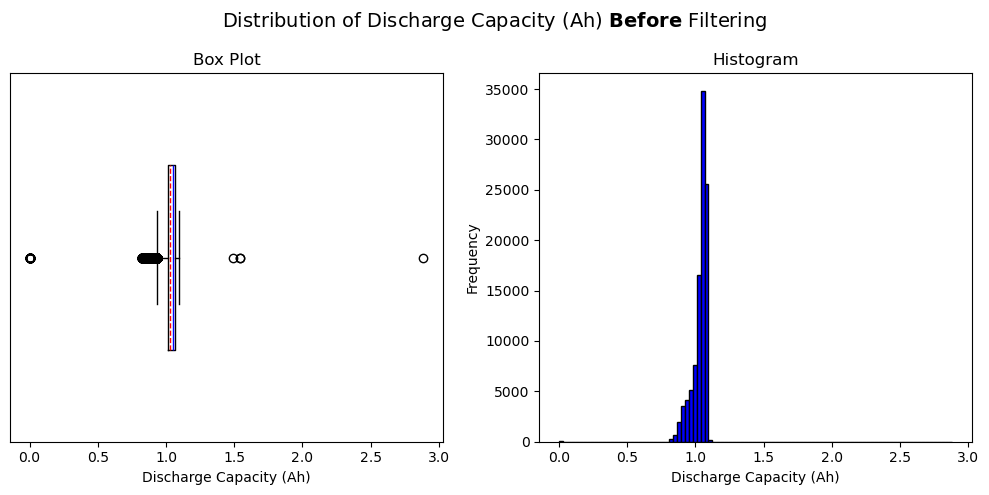

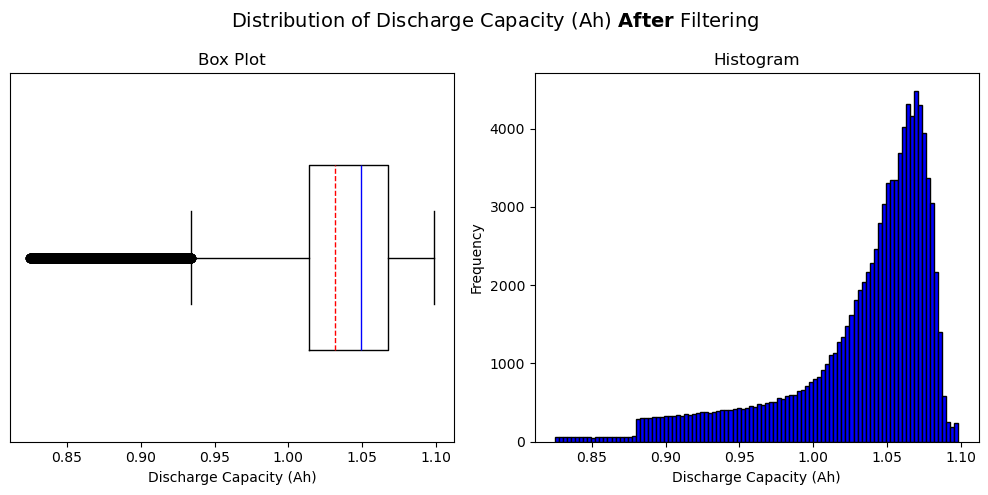

In [4]:

#! BEFORE FILTERING
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].boxplot(data=vis_qd, x='QD', vert=False, showmeans=True, meanline=True, meanprops={'color':'red'}, medianprops={'color':'blue'}, widths=0.5)
ax[0].set_title('Box Plot')
ax[0].set_xlabel('Discharge Capacity (Ah)')
ax[0].set_yticks([])

ax[1].hist(vis_qd.QD, bins=100, color='blue', edgecolor='black')
ax[1].set_title('Histogram')
ax[1].set_xlabel('Discharge Capacity (Ah)')
ax[1].set_ylabel('Frequency')

plt.suptitle(r'Distribution of Discharge Capacity (Ah) $\bf{Before}$ Filtering', fontsize=14)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/DistribCapactiryPreFilt.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

#! AFTER FILTERING
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].boxplot(data=vis_qd_filt, x='QD', vert=False, showmeans=True, meanline=True, meanprops={'color':'red'}, medianprops={'color':'blue'}, widths=0.5)
ax[0].set_title('Box Plot')
ax[0].set_xlabel('Discharge Capacity (Ah)')
ax[0].set_yticks([])

ax[1].hist(vis_qd_filt.QD, bins=100, color='blue', edgecolor='black')
ax[1].set_title('Histogram')
ax[1].set_xlabel('Discharge Capacity (Ah)')
ax[1].set_ylabel('Frequency')

plt.suptitle(r'Distribution of Discharge Capacity (Ah) $\bf{After}$ Filtering', fontsize=14)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/DistribCapactiryPostFilt.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()


## <span style='color:#003057'> Check if Charging Policy is Unique to Batch </span>

> The charging policy is an integral part of the cycle life of the battery, therefore this check ensures that the charging policy is unique to the batch.

In [5]:
check_policies = sum_raw.groupby('batch').agg({'charge_policy': 'nunique'}).query('charge_policy > 1')
if check_policies.empty:
    print('All batches have the same charge policy')
else:
    print('Batches with different charge policies:')
    display(check_policies)

print('Number of batches:', sum_raw.batch.nunique())
print('Number of number of unique charge policies:', sum_raw.charge_policy.nunique())

show_policies = sum_raw.groupby(['charge_policy']).agg({'batch': ['nunique','count',], 'cycle_life': ['min', 'max', 'mean', 'median', 'std']}).sort_values(by=('batch','nunique'), ascending=False)
printmd('### Charge Policy Statistics')
display(show_policies)

All batches have the same charge policy
Number of batches: 124
Number of number of unique charge policies: 69


### <span style="color:#54585A"> Charge Policy Statistics</span>

batch       cycle_life                     \
                            nunique count        min   max         mean   
charge_policy                                                             
5.3C(54%)-4C-newstructure         8  8587        935  1315  1088.082683   
5.6C(36%)-4.3C-newstructure       8  7439        786  1155   948.030649   
5.6C(19%)-4.6C-newstructure       7  6737        796  1146   983.118599   
5C(67%)-4C-newstructure           6  6688        813  1935  1260.682715   
4.8C(80%)-4.8C                    5  3013        461   870   623.410222   
4.8C(80%)-4.8C-newstructure       4  6349       1078  1836  1646.443849   
3.6C(80%)-3.6C                    3  6246       1852  2237  2096.289465   
6C(60%)-3C                        3  2231        713   757   733.799641   
3.7C(31%)-5.9C-newstructure       3  1977        541   772   673.532625   
5.4C(60%)-3C                      2  1597        719   880   807.615529   
5.4C(70%)-3C                      2  1477        691   788   742.685173   
5.4C(80%)-5.4C                    2  1091        534   559   546.786434   
5.9C(15%)-4.6C-newstructure       2  1732        858   876   867.093533   
5.9C(60%)-3.1C-newstructure       2  1731        731  1002   887.713460   
6C(40%)-3C                        2  1869        854  1017   942.607812   
6C(40%)-3.6C                      2  1710        842   870   856.229240   
4C(80%)-4C                        2  3141       1434  1709  1583.538364   
6C(50%)-3.6C                      2  1583        709   876   801.308907   
6C(50%)-3C                        2  1775        860   917   889.415211   
7C(30%)-3.6C                      2  1443        703   742   723.027027   
7C(40%)-3.6C                      2  1240        617   625   621.025806   
7C(40%)-3C                        2  1350        648   704   677.161481   
8C(15%)-3.6C                      2  2015        966  1051  1010.292804   
8C(25%)-3.6C                      2  1351        651   702   677.462620   
5.4C(60%)-3.6C                    2  1717        857   862   859.507280   
8C(35%)-3.6C                      2  1213        599   616   607.619126   
4C(40%)-6C                        1   520        483   483   483.000000   
6C(40%)-4C                        1   479        457   457   457.000000   
4.65C(19%)-4.85C                  1   520        489   489   489.000000   
4.4C(80%)-4.4C                    1  1073       1074  1074  1074.000000   
6C(20%)-4.5C                      1   492        466   466   466.000000   
6C(30%)-3.6C                      1  1013       1014  1014  1014.000000   
6C(31%)-4.25C                     1   487        462   462   462.000000   
6C(4%)-4.75C                      1   514        487   487   487.000000   
4.4C(8%)-4.85C                    1   531        502   502   502.000000   
4.4C(55%)-6C                      1   489        461   461   461.000000   
4.4C(47%)-5.5C                    1   523        487   487   487.000000   
5.6C(65%)-3C                      1   452        429   429   429.000000   
4.4C(24%)-5C                      1   525        494   494   494.000000   
6C(52%)-3.5C                      1   449        429   429   429.000000   
3.6C(9%)-5C                       1   596        561   561   561.000000   
3.6C(30%)-6C                      1   545        511   511   511.000000   
3.6C(22%)-5.5C                    1   471        444   444   444.000000   
3.6C(2%)-4.85C                    1   507        480   480   480.000000   
2C(7%)-5.5C                       1   361        335   335   335.000000   
2C(2%)-5C                         1   464        438   438   438.000000   
4.65C(44%)-5C                     1   540        513   513   513.000000   
5.6C(58%)-3.5C                    1   480        459   459   459.000000   
4C(4%)-4.85C                      1   509        485   485   485.000000   
5.4C(50%)-3C                      1   787        788   788   788.000000   
5.2C(10%)-4.75C                   1   507        481   

## <span style='color:#003057'> Check if Cycle Life matches the Total Cycles </span>

> One thing that I was interested in checking is whether or not the total # of cycles matches to what is listed for the cycle life in the source data, since it seemed like it was (offset by 1 index), but it's clear from the chart of discharge capacity vs. cycle number that some of the batteries seemed to be taken to much lower discharge capacities than others.
>
> This might make sense since in the paper, the authors define the cycle life as "the number of cycles until 80% of nominal capacity" (pg. 384), so it is possible that these batteries started with lower capacities than others. It's also not entirely clear what they're defining as "nominal capacity", is it the max capacity of the battery? Or is it the capacity at the beginning of the experiment? Or is it the rated capacity of the battery? I'm assuming it's the rated capacity of the battery, but it's not entirely clear.

In [6]:
test_cycles = sum_raw.groupby('batch')[['cycle', 'cycle_life']].agg('max')
test_cycles['offset'] = test_cycles['cycle'] - test_cycles['cycle_life']
mismatch_batches = test_cycles.query('offset != -1')

if mismatch_batches.empty:
    print('All batches have a cycle offset of -1')
else:
    printmd('Some Batches with a cycle offset other than -1:')
    print(f"Number of batches: {len(mismatch_batches):,} ({len(mismatch_batches)/len(test_cycles):.2%})")
    display(mismatch_batches)

Some Batches with a cycle offset other than -1:

Number of batches: 43 (34.68%)


,cycle,cycle_life,offset
batch,,,
b2c0,326,300,26
b2c1,170,148,22
b2c10,596,561,35
b2c11,505,477,28
b2c12,491,458,33
b2c13,520,483,37
b2c14,509,485,24
b2c17,525,494,31
b2c18,523,487,36


# <span style='color:#B3A369'> Data Handling </span>

## <span style='color:#003057'> Filter Data to prepare it for Analysis </span>

> The goal here is simply to filter the data to remove extreme outliers and to remove data that occurs after the cycle life is reached. 
>
> Here, we also add calculations for the % of maximum capacity and the % of nominal (1.1 Ah) capacity. This will help us see if the 1.1 Ah or the max capacity is what defines the cycle life.

In [7]:
sum_data = sum_raw.copy()

#! Filter out extreme QD values
upper_lim = 1.4
lower_lim = 0.6
sum_data = sum_data[(sum_data.QD < upper_lim) & (sum_data.QD > lower_lim)]


#! Move cycle to after cycle_life
idx = sum_data.columns.get_loc('cycle_life')
sum_data.insert(idx+1, 'cycle', sum_data.pop('cycle'))

#! Calculate QD as a percentage of max/nominal QD for each batch
sum_data['QD_PctMax'] = sum_data.QD / sum_data.groupby('batch')['QD'].transform('max')
sum_data['QD_PctNominal'] = sum_data.QD / 1.1

#! Filter out rows where cycle_life -1 > cycle
sum_data = sum_data[sum_data.cycle_life - 1 >= sum_data.cycle]

test_cycles_raise = sum_data.groupby('batch')[['cycle', 'cycle_life']].agg('max')
if not (test_cycles_raise['cycle'] - test_cycles_raise['cycle_life'] == -1).any():
    raise ValueError('Not all batches have a cycle offset of -1 after filtering.')

printmd('### Summary Data after Cleaning')
print(f'Number of rows before cleaning: {len(sum_raw):,}')
print(f'Number of rows after cleaning: {len(sum_data):,}')
print(f'Number of rows removed: {len(sum_raw) - len(sum_data):,}', f'({(len(sum_raw) - len(sum_data))/len(sum_raw):.2%})')
display(sum_data)

### <span style="color:#54585A"> Summary Data after Cleaning</span>

Number of rows before cleaning: 100,501
Number of rows after cleaning: 99,234
Number of rows removed: 1,267 (1.26%)


,batch,charge_policy,cycle_life,cycle,QD,QD_PctMax,QD_PctNominal
1,b1c0,3.6C(80%)-3.6C,1852,2,1.070689,0.994064,0.973354
2,b1c0,3.6C(80%)-3.6C,1852,3,1.071900,0.995189,0.974455
3,b1c0,3.6C(80%)-3.6C,1852,4,1.072510,0.995754,0.975009
4,b1c0,3.6C(80%)-3.6C,1852,5,1.073174,0.996371,0.975613
5,b1c0,3.6C(80%)-3.6C,1852,6,1.073576,0.996745,0.975978
...,...,...,...,...,...,...,...
100496,b3c45,4.8C(80%)-4.8C-newstructure,1801,1796,0.881539,0.822220,0.801399
100497,b3c45,4.8C(80%)-4.8C-newstructure,1801,1797,0.881441,0.822129,0.801310
100498,b3c45,4.8C(80%)-4.8C-newstructure,1801,1798,0.880883,0.821609,0.800803
100499,b3c45,4.8C(80%)-4.8C-newstructure,1801,1799,0.880757,0.821491,0.800688


## <span style='color:#003057'> Visualize Discharge Capacity </span>
 
> Based on the plot below, it's clear that the nominal discharge capacity is indeed 1.1 Ah, so we can use this to normalize the discharge capacity and model the % of discharge capacity based on the 1.1 Ah nominal capacity.

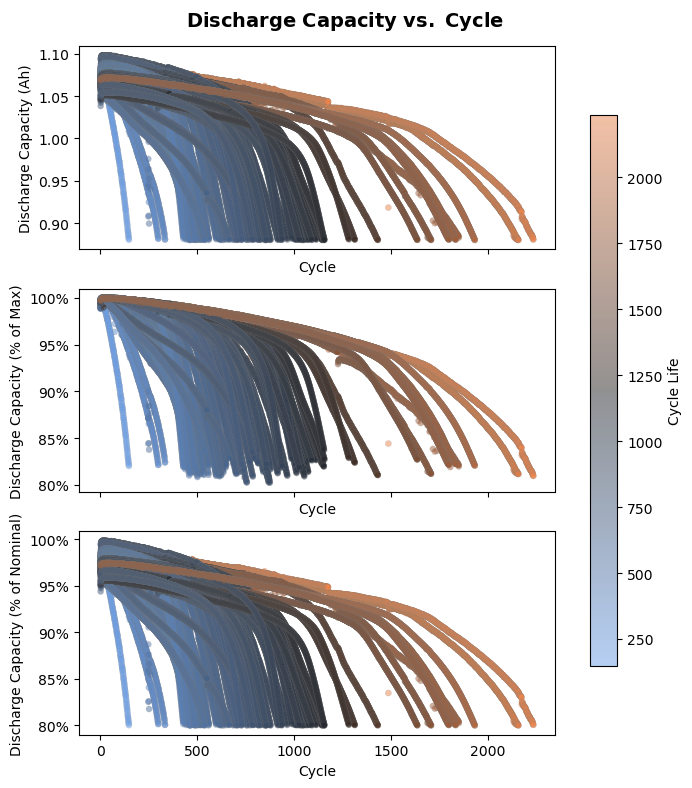

In [8]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

fig, axes = plt.subplots(3, 1, figsize=(7, 8), sharex=True)

y_vars = ['QD', 'QD_PctMax', 'QD_PctNominal']
y_names = ['Discharge Capacity (Ah)', 'Discharge Capacity (% of Max)', 'Discharge Capacity (% of Nominal)']
for id, (ax, y_var) in enumerate(zip(axes, y_vars)):
    sc = ax.scatter(
        sum_data['cycle'], sum_data[y_var], c=sum_data['cycle_life'], cmap=cmap, 
        vmin=sum_data['cycle_life'].min(), vmax=sum_data['cycle_life'].max(),
        s=20, alpha=0.5, 
        edgecolors='grey', linewidths=0.15
    )
    ax.set_xlabel('Cycle')
    ax.set_ylabel(y_names[id])
    if 'Pct' in y_var:
        #set y ticks to %
        ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

fig.suptitle(r'$\bf{Discharge\ Capacity\ vs.\ Cycle}$', fontsize=14)

plt.tight_layout()
fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='vertical', label='Cycle Life', shrink=0.8)
fig.subplots_adjust(right=0.8)
if pathlib.Path('figs').exists():
    plt.savefig('figs/ComarisonCapacityMetrics.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## <span style='color:#003057'> Final Summary Dataframe </span>

> For this, I decided to create a final dataframe with some column names that were more intuitive and easier to understand to me. I'll use this dataframe for the rest of the analysis.

In [9]:
data = sum_data.copy()
if 'QD_PctMax' in data.columns:
    data.drop(columns=['QD_PctMax'], inplace=True)

new_names = {
    'batch': 'BatteryID',
    'charge_policy': 'ChargingMethod',
    'cycle_life': 'CycleLife',
    'cycle': 'CycleNumber',
    # 'chargetime': 'TimeToCharge',
    # 'IR': 'InternalResistance',
    # 'Tavg': 'AvgTemperature',
    # 'Tmin': 'MinTemperature',
    # 'Tmax': 'MaxTemperature',
    # 'QC': 'ChargeCapacity',
    'QD': 'DischargeCapacity',
    'QD_PctNominal': 'PctNomDC',
    }

data.rename(columns=new_names, inplace=True)

#! make sure that all all keys of the dictionary are in the dataframe
assert all([col in data.columns for col in new_names.values()])

data['Failure'] = np.where(data.CycleLife == data.CycleNumber + 1, 1, 0)

data

,BatteryID,ChargingMethod,CycleLife,CycleNumber,DischargeCapacity,PctNomDC,Failure
1,b1c0,3.6C(80%)-3.6C,1852,2,1.070689,0.973354,0
2,b1c0,3.6C(80%)-3.6C,1852,3,1.071900,0.974455,0
3,b1c0,3.6C(80%)-3.6C,1852,4,1.072510,0.975009,0
4,b1c0,3.6C(80%)-3.6C,1852,5,1.073174,0.975613,0
5,b1c0,3.6C(80%)-3.6C,1852,6,1.073576,0.975978,0
...,...,...,...,...,...,...,...
100496,b3c45,4.8C(80%)-4.8C-newstructure,1801,1796,0.881539,0.801399,0
100497,b3c45,4.8C(80%)-4.8C-newstructure,1801,1797,0.881441,0.801310,0
100498,b3c45,4.8C(80%)-4.8C-newstructure,1801,1798,0.880883,0.800803,0
100499,b3c45,4.8C(80%)-4.8C-newstructure,1801,1799,0.880757,0.800688,0


# <span style='color:#B3A369'> Generate Model - Batch 3 </span>

> For the analysis, I have decided that the best option is likely going to be to focus on a specific batch since the charging policies vary between batches. I have chosen to focus on Batch 3 for a variety of reasons, but one of the major ones being that it generally has more runs per charging policy than the other batches. Additionally, it is also used in [State of health estimation for fast-charging lithium-ion battery based on incremental capacity analysis](https://www.sciencedirect.com/science/article/pii/S2352152X22005771#t0005) which I thought could be good for cross references.
>
> The goal of the analysis is to use Bayesian methods to determine if there is a statistically significant differnce in the cycle life between the different charging policies.

## <span style='color:#003057'> Filter for only Batch 3 and remove Categoricals </span>

> Since this data is now pretty small, there is no need to deal with the pains that come with categorical data (e.g. when trying to group or visualize the data), so I just transformed the categorical data into strings.

In [10]:
b3_data = data[data.BatteryID.str.contains('b3')]
b3_data.ChargingMethod = b3_data.ChargingMethod.astype(str)
b3_data['ChargingMethod'] = b3_data.ChargingMethod.str.strip().str.replace('-newstructure', '', regex=False)
b3_data.BatteryID = b3_data.BatteryID.astype(str)
b3_data

,BatteryID,ChargingMethod,CycleLife,CycleNumber,DischargeCapacity,PctNomDC,Failure
59261,b3c0,5C(67%)-4C,1009,1,1.066573,0.969612,0
59262,b3c0,5C(67%)-4C,1009,2,1.067455,0.970414,0
59263,b3c0,5C(67%)-4C,1009,3,1.068285,0.971168,0
59264,b3c0,5C(67%)-4C,1009,4,1.068708,0.971553,0
59265,b3c0,5C(67%)-4C,1009,5,1.069094,0.971903,0
...,...,...,...,...,...,...,...
100496,b3c45,4.8C(80%)-4.8C,1801,1796,0.881539,0.801399,0
100497,b3c45,4.8C(80%)-4.8C,1801,1797,0.881441,0.801310,0
100498,b3c45,4.8C(80%)-4.8C,1801,1798,0.880883,0.800803,0
100499,b3c45,4.8C(80%)-4.8C,1801,1799,0.880757,0.800688,0


## <span style='color:#003057'> Visualize Cycle Life based on Charging Policy </span>

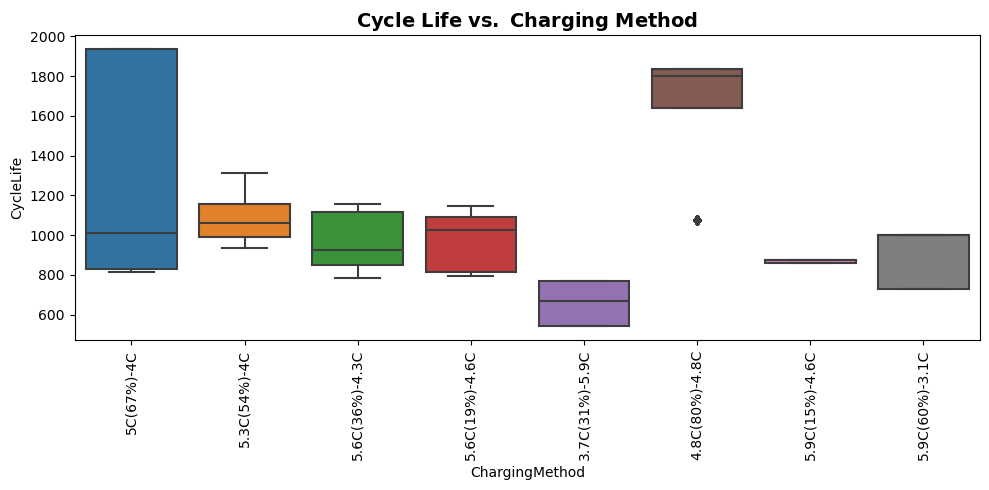

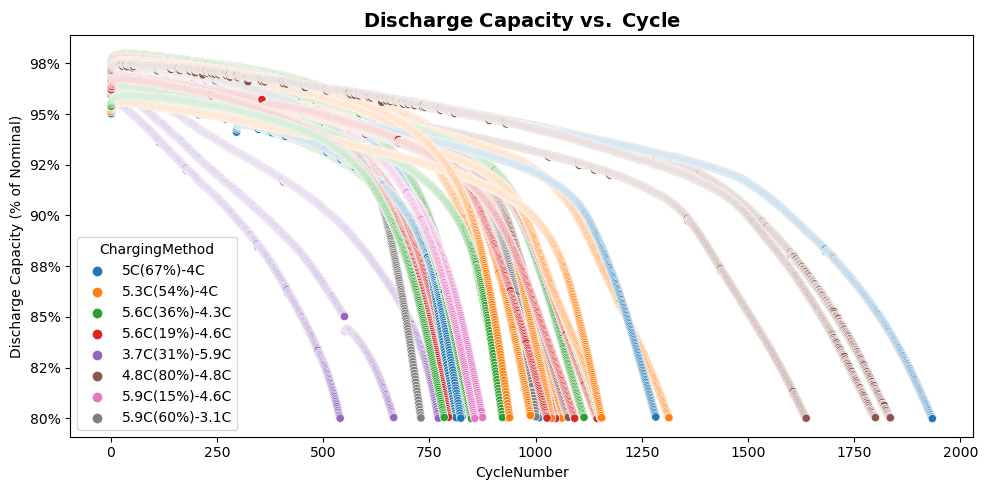

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='ChargingMethod', y='CycleLife', data=b3_data, ax=ax)
plt.title(r'$\bf{Cycle\ Life\ vs.\ Charging\ Method}$', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/BoxCycleLifevMethodB3.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(data = b3_data, x = 'CycleNumber', y='PctNomDC', hue='ChargingMethod')
plt.xlabel('CycleNumber')
plt.ylabel('Discharge Capacity (% of Nominal)')

plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in plt.gca().get_yticks()])

plt.title(r'$\bf{Discharge\ Capacity\ vs.\ Cycle}$', fontsize=14)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/NomCapvCycleB3Methods.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## <span style='color:#003057'> Split Visualization based on Charging Methods </span>

> I wanted to look more in depth to see if there are differences based on the groups in the [State of health estimation for fast-charging lithium-ion battery based on incremental capacity analysis](https://www.sciencedirect.com/science/article/pii/S2352152X22005771#t0005) I noticed that they excluded some batteries, but didn't mention why.
>
> Based on the graphs, it makes sense why `25` & `39` might be excluded (`25` has a low starting capacity and `39` is clearly a significant outlier), but I'm not sure why `36` was excluded.
>
> **NOTE:** I added +1 to the Battery ID to match the battery numbers listed in the above paper. This was just to make it easier to cross reference the data. Additionally, charging polcies `5.9C(15%)-4.6C` and `5.9C(60%)-3.1C` were excluded from the paper (I would assume becasue they only had two batteries worth of data included). The paper also included some of the noisy data which was deleted back in the 01 notebook by recommendation of the dataset creators. Those ones are not included in my analysis either.
>
> For my analysis, I'll be excluding `39` and `11` only since they are obvious outliers which I'm worried might skew my analysis. Unfortunately, I don't have enough technical knowledge to know if this is the best call or not.

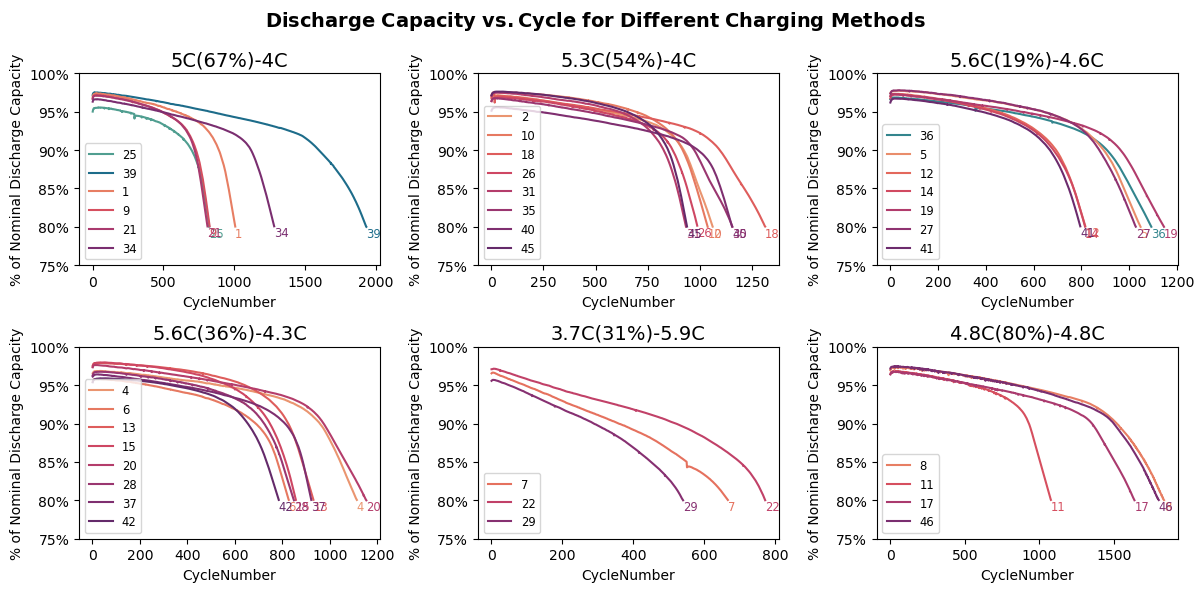

In [12]:
grps = [
    '5C(67%)-4C',
    '5.3C(54%)-4C',
    '5.6C(19%)-4.6C',
    '5.6C(36%)-4.3C',
    '3.7C(31%)-5.9C',
    '4.8C(80%)-4.8C',
    # '5.9C(60%)-3.1C',
    # '5.9C(15%)-4.6C',
]

excluded_batteries = [
    '25',
    '33',
    '36',
    '39',
]

vis_b3 = b3_data.copy()
vis_b3['Batch'] = vis_b3.BatteryID.str[1]
vis_b3['Battery'] = vis_b3.BatteryID.str[3:].astype(int)
vis_b3.Battery = vis_b3.Battery + 1
vis_b3.Battery = vis_b3.Battery.astype(str)
vis_b3['Excluded'] = np.where(vis_b3.Battery.isin(excluded_batteries), 1, 0)


n_cols = 3
n_rows = len(grps) // n_cols + (len(grps) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))

if n_rows > 1:
    axes = axes.flatten()

for idx, method in enumerate(grps):
    ax = axes[idx] if n_rows > 1 else axes

    sns.lineplot(
        data=vis_b3[(vis_b3.ChargingMethod == method) & (vis_b3.Excluded == 1)],
        x='CycleNumber', y='PctNomDC', hue='Battery', palette='crest', ax=ax
    )
    sns.lineplot(
        data=vis_b3[(vis_b3.ChargingMethod == method) & (vis_b3.Excluded == 0)],
        x='CycleNumber', y='PctNomDC', hue='Battery', palette='flare', ax=ax
    )

    ax.set_xlabel('CycleNumber')
    ax.set_ylabel('% of Nominal Discharge Capacity')
    ax.set_ylim(0.75, 1)
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    ax.set_title(method, fontsize=14)
    
    annots = [lab for lab in ax.get_legend_handles_labels()[1]]
    
    cnt = 0 
    for line in ax.lines:
        x, y = line.get_data()
        if len(x) > 0 and len(y) > 0: 
            label = annots[cnt]
            ax.text(x[-1], y[-1], f'{label}', color=line.get_color(), verticalalignment='top', fontsize='small')
            cnt += 1
    
    ax.legend(fontsize='small', markerscale=0.5, loc = 'lower left')
    

for idx in range(len(grps), n_rows * n_cols):
    if n_rows > 1:
        fig.delaxes(axes[idx])
    else:
        axes[idx].set_visible(False)

plt.suptitle(r'$\bf{Discharge\ Capacity\ vs. Cycle\ for\ Different\ Charging\ Methods}$', fontsize=14)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/NomCapMethodWOutlier.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()
    


## <span style='color:#003057'> Remove Charging Methods and Batteries </span>

> Final dataframe for analysis that removes the charging methods and batteries that were excluded based on the analysis in the previous cell.

Excluded 2 batteries: ['39', '11']
Excluded 2 methods: ['5.9C(60%)-3.1C', '5.9C(15%)-4.6C']


### <span style="color:#54585A"> Summary Data after Excluding Batteries and Methods</span>

,BatteryID,Batch,Battery,ChargingMethod,CycleLife,CycleNumber,DischargeCapacity,PctNomDC,Failure
59261,b3c0,3,1,5C(67%)-4C,1009,1,1.066573,0.969612,0
59262,b3c0,3,1,5C(67%)-4C,1009,2,1.067455,0.970414,0
59263,b3c0,3,1,5C(67%)-4C,1009,3,1.068285,0.971168,0
59264,b3c0,3,1,5C(67%)-4C,1009,4,1.068708,0.971553,0
59265,b3c0,3,1,5C(67%)-4C,1009,5,1.069094,0.971903,0
...,...,...,...,...,...,...,...,...,...
100496,b3c45,3,46,4.8C(80%)-4.8C,1801,1796,0.881539,0.801399,0
100497,b3c45,3,46,4.8C(80%)-4.8C,1801,1797,0.881441,0.801310,0
100498,b3c45,3,46,4.8C(80%)-4.8C,1801,1798,0.880883,0.800803,0
100499,b3c45,3,46,4.8C(80%)-4.8C,1801,1799,0.880757,0.800688,0


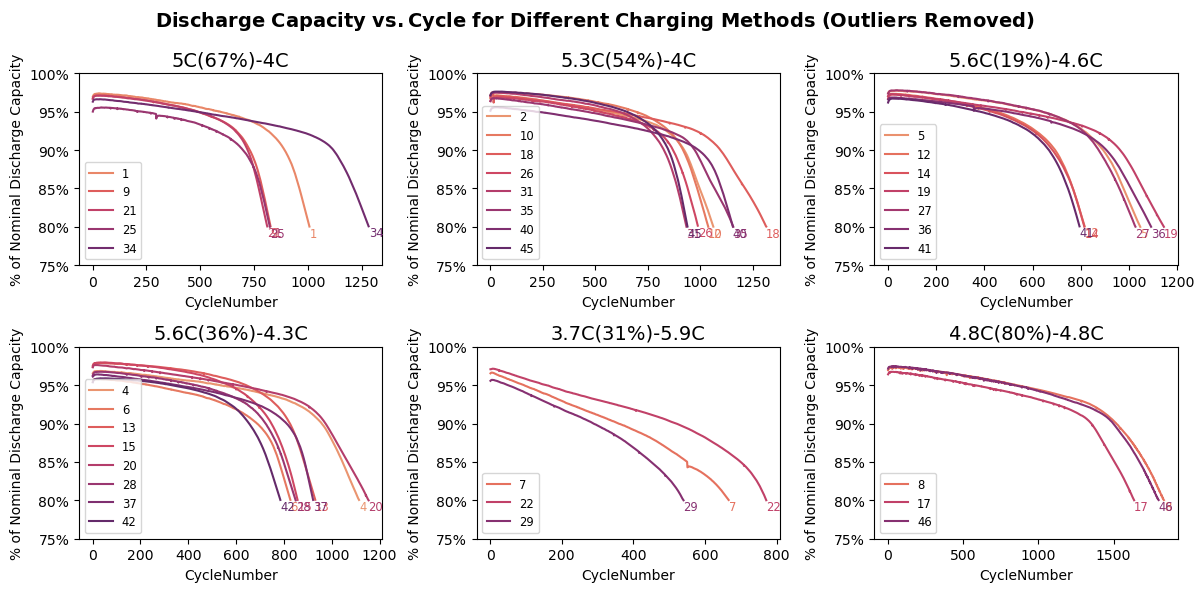

In [13]:
b3_analysis = b3_data.copy()

b3_analysis.insert(1, 'Batch', b3_analysis.BatteryID.str[1])
b3_analysis.insert(2, 'Battery', b3_analysis.BatteryID.str[3:].astype(int))
b3_analysis.Battery = b3_analysis.Battery + 1
b3_analysis.Battery = b3_analysis.Battery.astype(str)

bk_exclude_bats = [
    '39',
    # '25',
    '11',
]
bk_exclude_methods = [
    '5.9C(60%)-3.1C',
    '5.9C(15%)-4.6C',
]

b3_analysis = b3_analysis[~b3_analysis.Battery.isin(bk_exclude_bats)]
print(f'Excluded {len(bk_exclude_bats)} batteries: {bk_exclude_bats}')
b3_analysis = b3_analysis[~b3_analysis.ChargingMethod.isin(bk_exclude_methods)]
print(f'Excluded {len(bk_exclude_methods)} methods: {bk_exclude_methods}')

printmd('### Summary Data after Excluding Batteries and Methods')
display(b3_analysis)

n_cols = 3
n_rows = len(grps) // n_cols + (len(grps) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))

if n_rows > 1:
    axes = axes.flatten()

for idx, method in enumerate(grps):
    ax = axes[idx] if n_rows > 1 else axes

    sns.lineplot(
        data=b3_analysis[(b3_analysis.ChargingMethod == method)],
        x='CycleNumber', y='PctNomDC', hue='Battery', palette='flare', ax=ax
    )

    ax.set_xlabel('CycleNumber')
    ax.set_ylabel('% of Nominal Discharge Capacity')
    ax.set_ylim(0.75, 1)
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    ax.set_title(method, fontsize=14)
    
    annots = [lab for lab in ax.get_legend_handles_labels()[1]]
    
    cnt = 0 
    for line in ax.lines:
        x, y = line.get_data()
        if len(x) > 0 and len(y) > 0: 
            label = annots[cnt]
            ax.text(x[-1], y[-1], f'{label}', color=line.get_color(), verticalalignment='top', fontsize='small')
            cnt += 1
    
    ax.legend(fontsize='small', markerscale=0.5, loc = 'lower left')
    

for idx in range(len(grps), n_rows * n_cols):
    if n_rows > 1:
        fig.delaxes(axes[idx])
    else:
        axes[idx].set_visible(False)

plt.suptitle(r'$\bf{Discharge\ Capacity\ vs. Cycle\ for\ Different\ Charging\ Methods\ (Outliers\ Removed)}$', fontsize=14)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/NomCapMethodNoOutlier.png',bbox_inches='tight', pad_inches=0.01)
plt.show()
plt.close()

## <span style='color:#003057'> Create Final Model Data </span>

> Here I create the final data structure that will be used in the model by generating a dataframe of the life cycles of each battery.
>
> Importantly, we also add a numerical value for each charging method, this allows us to use the charging method as a feature in the model.

## <span style="color:#003057"> Final Data for model</span>

,Battery,ChargingMethod,CycleLife,ChargingMethod_Num
0,29,3.7C(31%)-5.9C,541,0
1,22,3.7C(31%)-5.9C,772,0
2,7,3.7C(31%)-5.9C,667,0
3,46,4.8C(80%)-4.8C,1801,1
4,8,4.8C(80%)-4.8C,1836,1
5,17,4.8C(80%)-4.8C,1638,1
6,40,5.3C(54%)-4C,1156,2
7,35,5.3C(54%)-4C,1158,2
8,31,5.3C(54%)-4C,935,2
9,45,5.3C(54%)-4C,940,2


## <span style="color:#003057"> Charging Method Category Map</span>

,ChargingMethod_Num,ChargingMethod
0,0,3.7C(31%)-5.9C
1,1,4.8C(80%)-4.8C
2,2,5.3C(54%)-4C
3,3,5.6C(19%)-4.6C
4,4,5.6C(36%)-4.3C
5,5,5C(67%)-4C


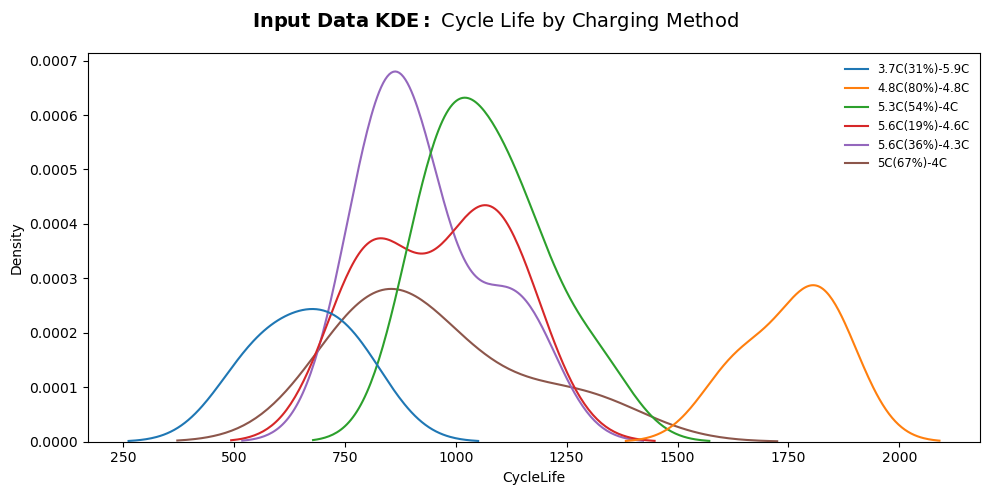

In [14]:
b3_final = b3_analysis.groupby(['Battery','ChargingMethod']).agg({'CycleLife': 'max'}).sort_values(by='ChargingMethod', ascending=True).reset_index()
b3_final['ChargingMethod_Num'] = b3_final['ChargingMethod'].astype('category').cat.codes
printmd('## Final Data for model')
display(b3_final)

cat_map = b3_final.groupby(['ChargingMethod_Num', 'ChargingMethod']).Battery.count().reset_index()
cat_map.drop(columns='Battery', inplace=True)
printmd('## Charging Method Category Map')
display(cat_map)
tbl_catmap = render_mpl_table(cat_map, header_columns=0, col_width=2.5)
if pathlib.Path('figs').exists():
    plt.savefig('figs/TblCatMap.png',bbox_inches='tight', pad_inches=0.01)
plt.close()
cat_map = cat_map.to_dict()['ChargingMethod']


plt.figure(figsize=(10, 5))
ax = sns.kdeplot(data=b3_final, x='CycleLife', hue='ChargingMethod', palette='tab10')
plt.suptitle(r'$\bf{Input\ Data\ KDE:}$ Cycle Life by Charging Method', fontsize=14)
sns.move_legend(ax, 'upper right', fontsize =  'small', title = None, frameon = False, markerscale = 0.5)
plt.tight_layout()
if pathlib.Path('figs').exists():
    plt.savefig('figs/KDEInputData.png',bbox_inches='tight', pad_inches=0.01)
plt.show()

## <span style='color:#003057'> Model of Cycle Life Based on Charging Method </span>

> This portion of the code models out the cycle life based on the charging method using `PyMC`. 

### <span style='color:#54585A'> Define function to Summarize PyMC Model </span>


In [15]:
def summarize_model(trace:  az.InferenceData, model_name: str,  use_hdi = 0.95, ) -> None:
    
    printmd(f'## {model_name} Information')
    
    hdi_map = {
        0.90: ['hdi_5%', 'hdi_95%'],
        0.95: ['hdi_2.5%', 'hdi_97.5%'],
    }
    
    #################################################
    #! SUMMARY
    #################################################
    summary = az.summary(trace, hdi_prob=use_hdi)  
    summary = summary[~summary.index.str.startswith('Δμ')]
    summary['HDI_Inc_0'] = (summary[hdi_map[use_hdi][0]] < 0) & (summary[hdi_map[use_hdi][1]] > 0)
    printmd('### Summary Statistics')
    display(summary)

    tbl_summary = render_mpl_table(summary, header_columns=0, col_width=1.5)
    if pathlib.Path('figs').exists():
        plt.savefig(f'figs/{model_name}_TblModelSummary.png',bbox_inches='tight', pad_inches=0.01)
    plt.close()
    
    #################################################
    #! TRACE PLOT
    #################################################
    az.plot_trace(trace, var_names=['μ', 'σ'],kind = 'rank_bars')
    plt.subplots_adjust(hspace=0.6)
    printmd('### Plot of Posterior Distribution of Means')
    if pathlib.Path('figs').exists():
        plt.savefig(f'figs/{model_name}_AzTrace.png',bbox_inches='tight', pad_inches=0.01)
    plt.show()
    plt.close()
    
    #################################################
    #! KDE OF Charging Method
    #################################################
    printmd('### KDE of Cycle Life by Charging Method (Observed & Model)')
    chain0 = pd.DataFrame(trace.posterior['μ'].values[0], columns=cat_map.values()).stack().reset_index().rename(columns={'level_0':'sample', 'level_1':'ChargingMethod', 0:'CycleLife'})

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    ax0 = sns.kdeplot(data=b3_final, x='CycleLife', hue='ChargingMethod', palette='tab10', ax=axes[0])
    axes[0].set_title('Input Data', fontsize=14)
    sns.move_legend(ax0, 'upper right', fontsize =  'small', title = None, frameon = False, markerscale = 0.5)

    ax1 = sns.kdeplot(data=chain0, x='CycleLife', hue='ChargingMethod', palette='tab10', ax=axes[1])
    axes[1].set_title('Model Data (Chain 0)', fontsize=14)
    sns.move_legend(ax1, 'upper right', fontsize =  'small', title = None, frameon = False, markerscale = 0.5)


    plt.suptitle(r'$\bf{KDE: Cycle\ Life\ by\ Charging\ Method}$', fontsize=14)
    if pathlib.Path('figs').exists():
        plt.savefig(f'figs/{model_name}_KdeInputvModel.png',bbox_inches='tight', pad_inches=0.01)
    plt.tight_layout()
    plt.show()
    plt.close()


    #################################################
    #! DIFFERENCES IN MEANS
    #################################################

    diffs_summary = az.summary(trace, var_names=['~μ','~σ'], hdi_prob=use_hdi)
    diffs_summary = diffs_summary[diffs_summary.index.str.startswith('Δμ')]
    diffs_summary['HDI_Inc_0'] = (diffs_summary[hdi_map[use_hdi][0]] < 0) & (diffs_summary[hdi_map[use_hdi][1]] > 0)

    printmd('### Summary Statistics of Differences in Means')
    display(diffs_summary)

    tbl_diffs = render_mpl_table(diffs_summary, header_columns=0, col_width=1.5)
    if pathlib.Path('figs').exists():
        plt.savefig(f'figs/{model_name}_TblDiffSummary.png',bbox_inches='tight', pad_inches=0.01)
    plt.close()

    #################################################
    #! DIFFERENCES IN MEANS (SHORT)
    #################################################
    diff_sum_new = diffs_summary.copy()
    diff_sum_new.index = diff_sum_new.index.str.replace('Δμ_', 'Δμ ')
    diff_sum_new.index = diff_sum_new.index.str.replace('_', ' vs. ')

    # replace the numbers with the actual charging method
    diff_sum_new.index = diff_sum_new.index.str.replace(r'\d', lambda x: cat_map[int(x.group(0))], regex=True)
    diff_sum_new.drop(columns = ['mcse_mean','mcse_sd','ess_bulk','ess_tail','r_hat'], inplace=True)
    printmd('### Summary Statistics of Differences in Means (Replaced Names)')
    display(diff_sum_new)

    tbl_diffs_new = render_mpl_table(diff_sum_new, header_columns=0, col_width=1.5)
    if pathlib.Path('figs').exists():
        plt.savefig(f'figs/{model_name}_TblDiffSummaryShort.png',bbox_inches='tight', pad_inches=0.01)
    plt.close()

### <span style='color:#54585A'> Build models with Different Prior Estimates </span>


# <span style="color:#B3A369"> Generating Models of Cycle Life based on Charging Method</span>

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


## <span style="color:#003057"> HalfNormal Information</span>

### <span style="color:#54585A"> Summary Statistics</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
μ[0],728.377,43.882,642.502,814.618,0.288,0.205,23247.0,15371.0,1.0,False
μ[1],1621.086,45.055,1533.155,1709.239,0.302,0.213,22321.0,16539.0,1.0,False
μ[2],1070.234,28.312,1014.286,1125.382,0.178,0.126,25285.0,16249.0,1.0,False
μ[3],969.300,29.691,911.748,1027.230,0.194,0.137,23395.0,15876.0,1.0,False
μ[4],938.009,27.960,883.608,992.703,0.164,0.116,29123.0,16741.0,1.0,False
μ[5],960.212,35.180,890.818,1028.177,0.217,0.153,26352.0,15960.0,1.0,False
σ,83.062,4.787,74.119,92.730,0.033,0.023,21097.0,17632.0,1.0,False


### <span style="color:#54585A"> Plot of Posterior Distribution of Means</span>

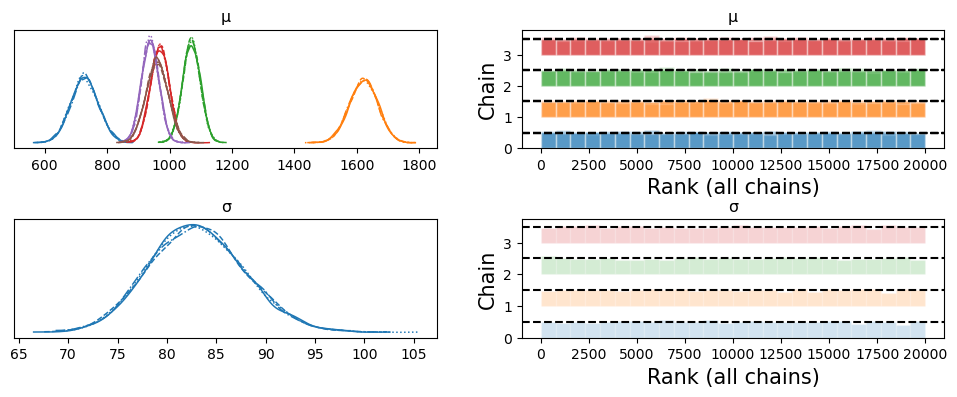

### <span style="color:#54585A"> KDE of Cycle Life by Charging Method (Observed & Model)</span>

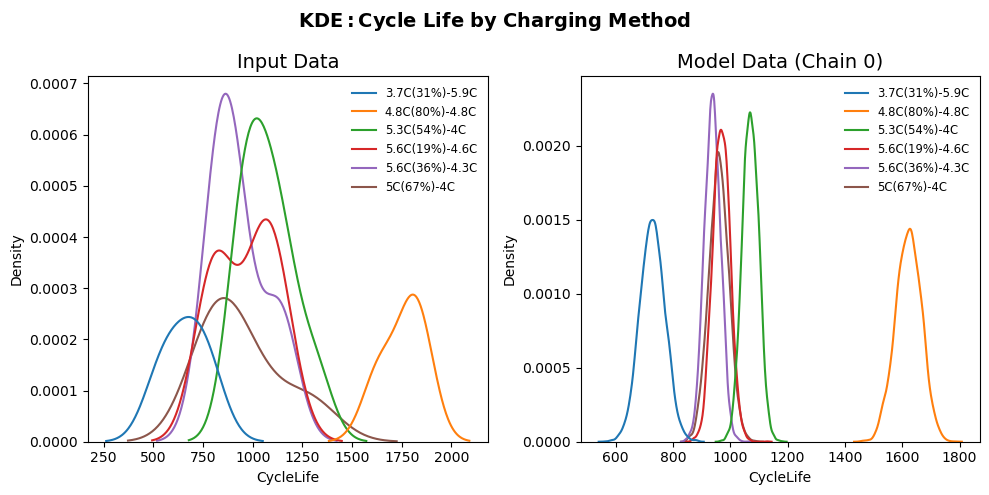

### <span style="color:#54585A"> Summary Statistics of Differences in Means</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
Δμ_0_1,-892.709,64.572,-1018.740,-766.611,0.451,0.319,20568.0,15830.0,1.0,False
Δμ_0_2,-341.857,52.250,-442.952,-238.342,0.341,0.241,23505.0,16050.0,1.0,False
Δμ_0_3,-240.923,52.586,-344.406,-138.970,0.343,0.243,23591.0,16357.0,1.0,False
Δμ_0_4,-209.632,51.391,-309.920,-110.452,0.326,0.231,24806.0,16216.0,1.0,False
Δμ_0_5,-231.835,56.070,-336.672,-117.084,0.354,0.253,25094.0,16633.0,1.0,False
Δμ_1_2,550.852,53.062,447.733,655.170,0.338,0.239,24738.0,16310.0,1.0,False
Δμ_1_3,651.786,54.191,540.820,752.330,0.366,0.259,22024.0,16676.0,1.0,False
Δμ_1_4,683.077,53.262,581.953,790.269,0.353,0.250,22795.0,16241.0,1.0,False
Δμ_1_5,660.874,57.054,551.567,775.161,0.377,0.266,23027.0,17135.0,1.0,False
Δμ_2_3,100.934,41.120,20.749,182.271,0.264,0.194,24356.0,15997.0,1.0,False


### <span style="color:#54585A"> Summary Statistics of Differences in Means (Replaced Names)</span>

,mean,sd,hdi_2.5%,hdi_97.5%,HDI_Inc_0
Δμ 3.7C(31%)-5.9C vs. 4.8C(80%)-4.8C,-892.709,64.572,-1018.740,-766.611,False
Δμ 3.7C(31%)-5.9C vs. 5.3C(54%)-4C,-341.857,52.250,-442.952,-238.342,False
Δμ 3.7C(31%)-5.9C vs. 5.6C(19%)-4.6C,-240.923,52.586,-344.406,-138.970,False
Δμ 3.7C(31%)-5.9C vs. 5.6C(36%)-4.3C,-209.632,51.391,-309.920,-110.452,False
Δμ 3.7C(31%)-5.9C vs. 5C(67%)-4C,-231.835,56.070,-336.672,-117.084,False
Δμ 4.8C(80%)-4.8C vs. 5.3C(54%)-4C,550.852,53.062,447.733,655.170,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(19%)-4.6C,651.786,54.191,540.820,752.330,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(36%)-4.3C,683.077,53.262,581.953,790.269,False
Δμ 4.8C(80%)-4.8C vs. 5C(67%)-4C,660.874,57.054,551.567,775.161,False
Δμ 5.3C(54%)-4C vs. 5.6C(19%)-4.6C,100.934,41.120,20.749,182.271,False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.


## <span style="color:#003057"> Normal Information</span>

### <span style="color:#54585A"> Summary Statistics</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
σ,83.046,4.777,73.821,92.477,0.033,0.023,20902.0,16807.0,1.0,False
μ[0],728.160,43.701,644.802,815.188,0.282,0.200,24075.0,15322.0,1.0,False
μ[1],1621.002,45.152,1535.062,1712.909,0.322,0.228,19646.0,16112.0,1.0,False
μ[2],1070.427,28.435,1013.999,1125.484,0.189,0.134,22507.0,15869.0,1.0,False
μ[3],968.794,30.411,907.814,1026.670,0.191,0.135,25537.0,15542.0,1.0,False
μ[4],938.122,28.577,883.960,995.423,0.168,0.119,28925.0,16118.0,1.0,False
μ[5],960.694,34.926,892.734,1030.127,0.227,0.160,23740.0,15534.0,1.0,False


### <span style="color:#54585A"> Plot of Posterior Distribution of Means</span>

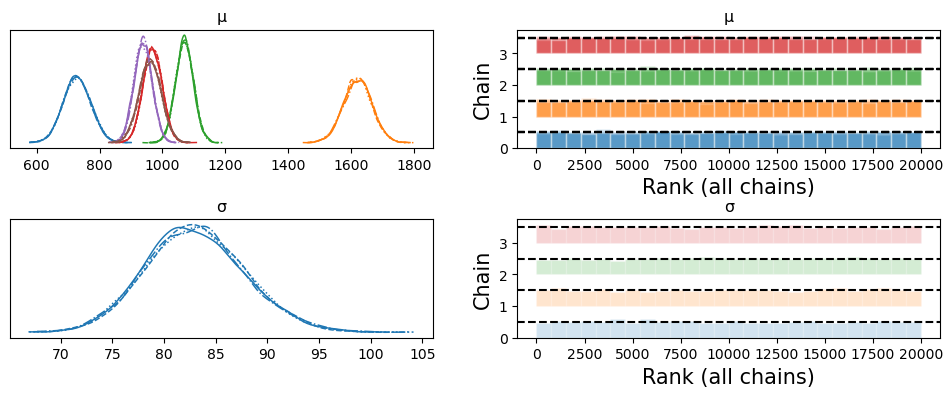

### <span style="color:#54585A"> KDE of Cycle Life by Charging Method (Observed & Model)</span>

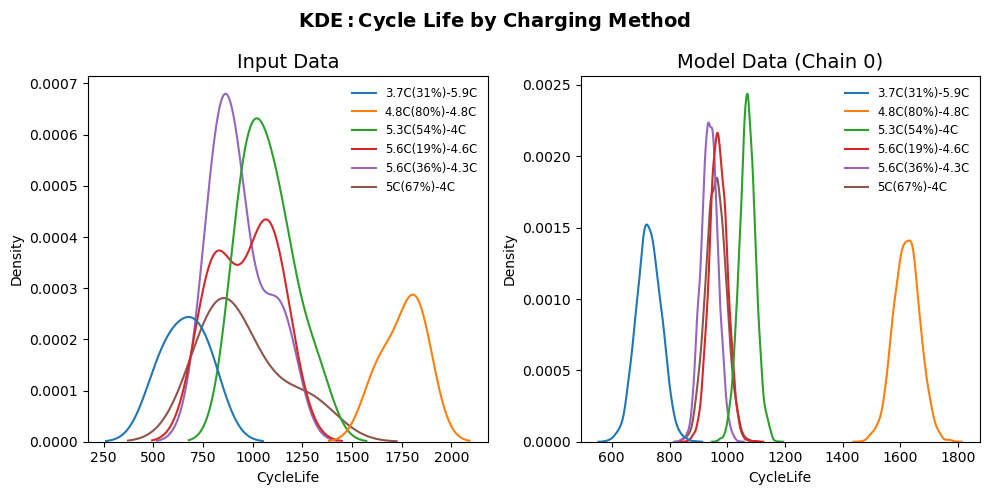

### <span style="color:#54585A"> Summary Statistics of Differences in Means</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
Δμ_0_1,-892.842,64.389,-1018.484,-765.241,0.460,0.325,19667.0,16348.0,1.0,False
Δμ_0_2,-342.267,52.596,-442.765,-237.919,0.347,0.248,22944.0,16073.0,1.0,False
Δμ_0_3,-240.634,53.281,-342.719,-133.413,0.343,0.244,24210.0,15810.0,1.0,False
Δμ_0_4,-209.962,52.116,-314.986,-110.159,0.330,0.237,24892.0,15597.0,1.0,False
Δμ_0_5,-232.534,55.624,-340.460,-122.656,0.355,0.253,24580.0,16993.0,1.0,False
Δμ_1_2,550.575,53.168,448.401,657.348,0.371,0.262,20594.0,16577.0,1.0,False
Δμ_1_3,652.208,54.838,546.548,760.965,0.380,0.268,20982.0,16396.0,1.0,False
Δμ_1_4,682.881,53.772,571.291,784.098,0.367,0.260,21461.0,16264.0,1.0,False
Δμ_1_5,660.308,56.750,551.764,772.878,0.399,0.282,20230.0,16554.0,1.0,False
Δμ_2_3,101.633,41.606,19.566,182.101,0.266,0.195,24421.0,16233.0,1.0,False


### <span style="color:#54585A"> Summary Statistics of Differences in Means (Replaced Names)</span>

,mean,sd,hdi_2.5%,hdi_97.5%,HDI_Inc_0
Δμ 3.7C(31%)-5.9C vs. 4.8C(80%)-4.8C,-892.842,64.389,-1018.484,-765.241,False
Δμ 3.7C(31%)-5.9C vs. 5.3C(54%)-4C,-342.267,52.596,-442.765,-237.919,False
Δμ 3.7C(31%)-5.9C vs. 5.6C(19%)-4.6C,-240.634,53.281,-342.719,-133.413,False
Δμ 3.7C(31%)-5.9C vs. 5.6C(36%)-4.3C,-209.962,52.116,-314.986,-110.159,False
Δμ 3.7C(31%)-5.9C vs. 5C(67%)-4C,-232.534,55.624,-340.460,-122.656,False
Δμ 4.8C(80%)-4.8C vs. 5.3C(54%)-4C,550.575,53.168,448.401,657.348,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(19%)-4.6C,652.208,54.838,546.548,760.965,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(36%)-4.3C,682.881,53.772,571.291,784.098,False
Δμ 4.8C(80%)-4.8C vs. 5C(67%)-4C,660.308,56.750,551.764,772.878,False
Δμ 5.3C(54%)-4C vs. 5.6C(19%)-4.6C,101.633,41.606,19.566,182.101,False


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


## <span style="color:#003057"> HalfCauchy Information</span>

### <span style="color:#54585A"> Summary Statistics</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
μ[0],870.602,81.490,708.834,1029.362,0.565,0.403,20893.0,15087.0,1.0,False
μ[1],1335.197,95.565,1142.751,1513.836,0.740,0.523,16695.0,14486.0,1.0,False
μ[2],1056.910,58.445,939.496,1169.200,0.382,0.270,23462.0,15597.0,1.0,False
μ[3],985.239,61.136,867.150,1106.155,0.393,0.279,24407.0,14732.0,1.0,False
μ[4],962.843,58.938,845.827,1078.075,0.384,0.274,23660.0,15113.0,1.0,False
μ[5],983.792,68.633,849.101,1117.326,0.453,0.322,22960.0,14429.0,1.0,False
σ,205.674,34.864,143.054,275.577,0.288,0.205,14835.0,15267.0,1.0,False


### <span style="color:#54585A"> Plot of Posterior Distribution of Means</span>

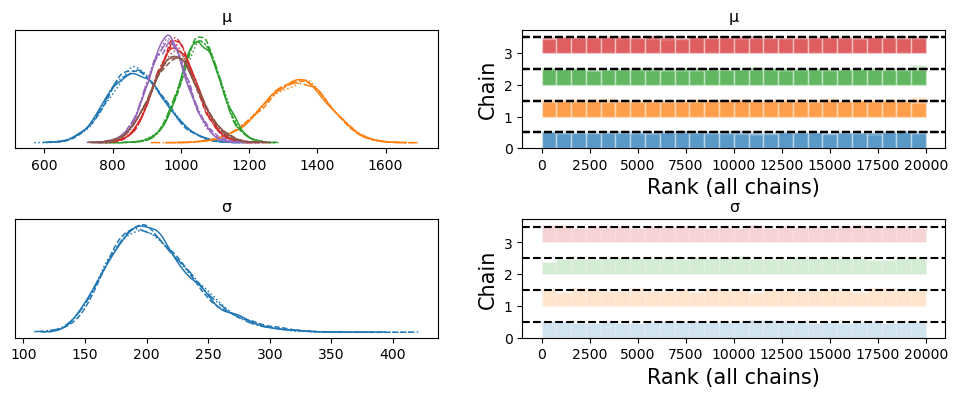

### <span style="color:#54585A"> KDE of Cycle Life by Charging Method (Observed & Model)</span>

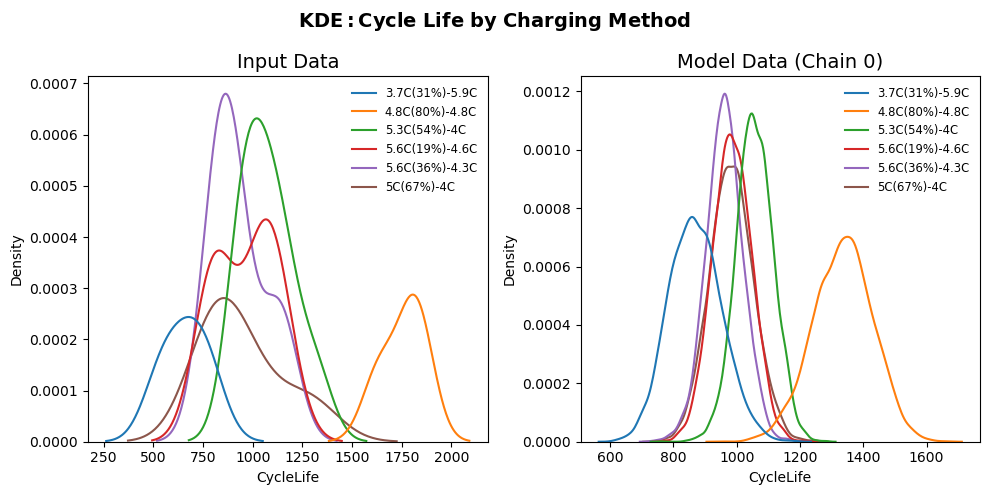

### <span style="color:#54585A"> Summary Statistics of Differences in Means</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
Δμ_0_1,-464.595,137.644,-724.747,-189.420,1.119,0.792,15177.0,14339.0,1.0,False
Δμ_0_2,-186.308,100.275,-380.191,13.823,0.702,0.505,20421.0,15162.0,1.0,True
Δμ_0_3,-114.636,100.454,-310.413,82.642,0.670,0.527,22573.0,14567.0,1.0,True
Δμ_0_4,-92.241,99.045,-287.403,98.735,0.656,0.532,22948.0,15323.0,1.0,True
Δμ_0_5,-113.190,105.557,-319.106,93.701,0.693,0.561,23279.0,14858.0,1.0,True
Δμ_1_2,278.287,110.485,60.803,489.932,0.795,0.562,19439.0,15547.0,1.0,False
Δμ_1_3,349.958,116.965,111.316,572.118,0.888,0.628,17470.0,14120.0,1.0,False
Δμ_1_4,372.354,115.678,152.861,603.742,0.894,0.632,16946.0,14467.0,1.0,False
Δμ_1_5,351.405,120.170,112.156,581.723,0.917,0.649,17319.0,13751.0,1.0,False
Δμ_2_3,71.671,85.122,-91.814,245.436,0.562,0.488,23130.0,15283.0,1.0,True


### <span style="color:#54585A"> Summary Statistics of Differences in Means (Replaced Names)</span>

,mean,sd,hdi_2.5%,hdi_97.5%,HDI_Inc_0
Δμ 3.7C(31%)-5.9C vs. 4.8C(80%)-4.8C,-464.595,137.644,-724.747,-189.420,False
Δμ 3.7C(31%)-5.9C vs. 5.3C(54%)-4C,-186.308,100.275,-380.191,13.823,True
Δμ 3.7C(31%)-5.9C vs. 5.6C(19%)-4.6C,-114.636,100.454,-310.413,82.642,True
Δμ 3.7C(31%)-5.9C vs. 5.6C(36%)-4.3C,-92.241,99.045,-287.403,98.735,True
Δμ 3.7C(31%)-5.9C vs. 5C(67%)-4C,-113.190,105.557,-319.106,93.701,True
Δμ 4.8C(80%)-4.8C vs. 5.3C(54%)-4C,278.287,110.485,60.803,489.932,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(19%)-4.6C,349.958,116.965,111.316,572.118,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(36%)-4.3C,372.354,115.678,152.861,603.742,False
Δμ 4.8C(80%)-4.8C vs. 5C(67%)-4C,351.405,120.170,112.156,581.723,False
Δμ 5.3C(54%)-4C vs. 5.6C(19%)-4.6C,71.671,85.122,-91.814,245.436,True


In [16]:
rng = np.random.default_rng(903027850)

#################################################
#! MODELS
#################################################
printmd('# Generating Models of Cycle Life based on Charging Method')
with pm.Model() as model_HN:
    
    sd = pm.HalfNormal('σ', 10)
    
    means = pm.Normal(
        'μ', mu=b3_final['CycleLife'].mean(), tau = 0.0001, 
        shape=len(b3_final['ChargingMethod'].unique())
        )
    
    likelihood = pm.Normal(
        'likelihood', 
        mu=means[b3_final['ChargingMethod_Num']], 
        sigma=sd, 
        observed=b3_final['CycleLife']
        )
    
    for i in range(len(b3_final['ChargingMethod'].unique())):
        for j in range(i+1, len(b3_final['ChargingMethod'].unique())):
            pm.Deterministic(f'Δμ_{i}_{j}', means[i] - means[j])

    trace_HN = pm.sample(
        5000,
        tune=1000,
        return_inferencedata=True, 
        idata_kwargs=dict(log_likelihood=True),
        random_seed=rng,
    )
    # ppc_HN = pm.sample_posterior_predictive(trace_HN,extend_inferencedata=True,random_seed=rng)

summarize_model(trace_HN, 'HalfNormal')

with pm.Model() as model_N:
    sd = pm.Normal('σ', mu = 0, sigma = 10)
    
    means = pm.Normal(
        'μ', mu=b3_final['CycleLife'].mean(), tau = 0.0001, 
        shape=len(b3_final['ChargingMethod'].unique())
        )

    likelihood = pm.Normal(
        'likelihood', 
        mu=means[b3_final['ChargingMethod_Num']], 
        sigma=sd, 
        observed=b3_final['CycleLife']
        )
    
    for i in range(len(b3_final['ChargingMethod'].unique())):
        for j in range(i+1, len(b3_final['ChargingMethod'].unique())):
            pm.Deterministic(f'Δμ_{i}_{j}', means[i] - means[j])

    trace_N = pm.sample(
        5000,
        tune=1000,
        return_inferencedata=True, 
        idata_kwargs=dict(log_likelihood=True),
        random_seed=rng,
    )
    
    # ppc_N = pm.sample_posterior_predictive(trace_N,extend_inferencedata=True,random_seed=rng)

summarize_model(trace_N, 'Normal')

with pm.Model() as model_HC:
    sd = pm.HalfCauchy('σ', 10)
    
    means = pm.Normal(
        'μ', mu=b3_final['CycleLife'].mean(), tau = 0.0001, 
        shape=len(b3_final['ChargingMethod'].unique())
        )
    
    likelihood = pm.Normal(
        'likelihood', 
        mu=means[b3_final['ChargingMethod_Num']], 
        sigma=sd, 
        observed=b3_final['CycleLife']
        )
    
    for i in range(len(b3_final['ChargingMethod'].unique())):
        for j in range(i+1, len(b3_final['ChargingMethod'].unique())):
            pm.Deterministic(f'Δμ_{i}_{j}', means[i] - means[j])

    trace_HC = pm.sample(
        5000,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs=dict(log_likelihood=True),
        random_seed=rng,
    )
    # ppc_HC = pm.sample_posterior_predictive(trace_HC,extend_inferencedata=True,random_seed=rng)

summarize_model(trace_HC, 'HalfCauchy')



### <span style='color:#54585A'> Determine Best model based on Loo </span>

> Utilizes `PyMC` `loo()` function to determine the best model. 

In [17]:
with model_N:
    loo_N = pm.loo(trace_N, scale='log')

with model_HN:
    loo_HN = pm.loo(trace_HN, scale='log')

with model_HC:
    loo_HC = pm.loo(trace_HC, scale='log')

#https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood
df_comp_loo = az.compare({"Normal": loo_N, "HalfNormal": loo_HN, "HalfCauchy": loo_HC})
df_comp_loo = df_comp_loo.round(4)

tbl_comp_loo = render_mpl_table(df_comp_loo, header_columns=0, col_width=1.5)
if pathlib.Path('figs').exists():
    plt.savefig(f'figs/ModelComparison.png',bbox_inches='tight', pad_inches=0.01)
plt.close()
display(df_comp_loo)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
HalfCauchy,0,-232.0127,4.7126,0.0000,0.6413,4.6693,0.0000,False,log
HalfNormal,1,-243.3320,18.0994,11.3193,0.3587,11.5009,9.6640,True,log
Normal,2,-243.7511,18.5439,11.7383,0.0000,11.5923,9.7599,True,log


### <span style='color:#54585A'> Best Model Information </span>


# <span style="color:#B3A369"> Best Model: HalfCauchy</span>

## <span style="color:#003057"> Best_HalfCauchy Information</span>

### <span style="color:#54585A"> Summary Statistics</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
μ[0],870.602,81.490,708.834,1029.362,0.565,0.403,20893.0,15087.0,1.0,False
μ[1],1335.197,95.565,1142.751,1513.836,0.740,0.523,16695.0,14486.0,1.0,False
μ[2],1056.910,58.445,939.496,1169.200,0.382,0.270,23462.0,15597.0,1.0,False
μ[3],985.239,61.136,867.150,1106.155,0.393,0.279,24407.0,14732.0,1.0,False
μ[4],962.843,58.938,845.827,1078.075,0.384,0.274,23660.0,15113.0,1.0,False
μ[5],983.792,68.633,849.101,1117.326,0.453,0.322,22960.0,14429.0,1.0,False
σ,205.674,34.864,143.054,275.577,0.288,0.205,14835.0,15267.0,1.0,False


### <span style="color:#54585A"> Plot of Posterior Distribution of Means</span>

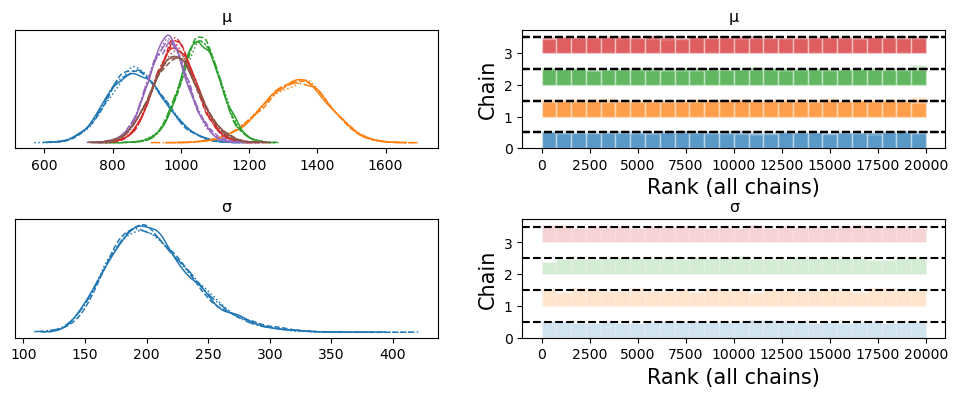

### <span style="color:#54585A"> KDE of Cycle Life by Charging Method (Observed & Model)</span>

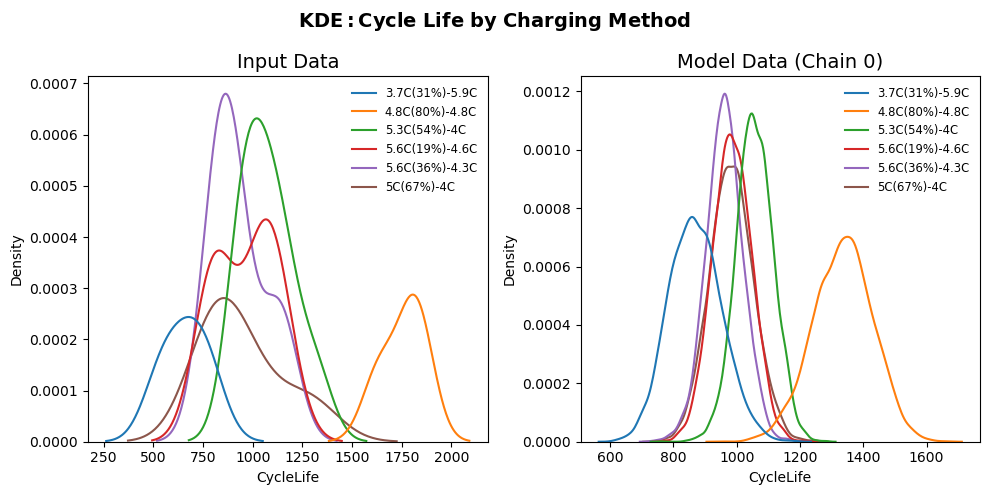

### <span style="color:#54585A"> Summary Statistics of Differences in Means</span>

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,HDI_Inc_0
Δμ_0_1,-464.595,137.644,-724.747,-189.420,1.119,0.792,15177.0,14339.0,1.0,False
Δμ_0_2,-186.308,100.275,-380.191,13.823,0.702,0.505,20421.0,15162.0,1.0,True
Δμ_0_3,-114.636,100.454,-310.413,82.642,0.670,0.527,22573.0,14567.0,1.0,True
Δμ_0_4,-92.241,99.045,-287.403,98.735,0.656,0.532,22948.0,15323.0,1.0,True
Δμ_0_5,-113.190,105.557,-319.106,93.701,0.693,0.561,23279.0,14858.0,1.0,True
Δμ_1_2,278.287,110.485,60.803,489.932,0.795,0.562,19439.0,15547.0,1.0,False
Δμ_1_3,349.958,116.965,111.316,572.118,0.888,0.628,17470.0,14120.0,1.0,False
Δμ_1_4,372.354,115.678,152.861,603.742,0.894,0.632,16946.0,14467.0,1.0,False
Δμ_1_5,351.405,120.170,112.156,581.723,0.917,0.649,17319.0,13751.0,1.0,False
Δμ_2_3,71.671,85.122,-91.814,245.436,0.562,0.488,23130.0,15283.0,1.0,True


### <span style="color:#54585A"> Summary Statistics of Differences in Means (Replaced Names)</span>

,mean,sd,hdi_2.5%,hdi_97.5%,HDI_Inc_0
Δμ 3.7C(31%)-5.9C vs. 4.8C(80%)-4.8C,-464.595,137.644,-724.747,-189.420,False
Δμ 3.7C(31%)-5.9C vs. 5.3C(54%)-4C,-186.308,100.275,-380.191,13.823,True
Δμ 3.7C(31%)-5.9C vs. 5.6C(19%)-4.6C,-114.636,100.454,-310.413,82.642,True
Δμ 3.7C(31%)-5.9C vs. 5.6C(36%)-4.3C,-92.241,99.045,-287.403,98.735,True
Δμ 3.7C(31%)-5.9C vs. 5C(67%)-4C,-113.190,105.557,-319.106,93.701,True
Δμ 4.8C(80%)-4.8C vs. 5.3C(54%)-4C,278.287,110.485,60.803,489.932,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(19%)-4.6C,349.958,116.965,111.316,572.118,False
Δμ 4.8C(80%)-4.8C vs. 5.6C(36%)-4.3C,372.354,115.678,152.861,603.742,False
Δμ 4.8C(80%)-4.8C vs. 5C(67%)-4C,351.405,120.170,112.156,581.723,False
Δμ 5.3C(54%)-4C vs. 5.6C(19%)-4.6C,71.671,85.122,-91.814,245.436,True


In [18]:
best_model = df_comp_loo.index[0]

printmd(f'# Best Model: {best_model}')

assert best_model in ['Normal', 'HalfNormal', 'HalfCauchy']

if best_model == 'HalfCauchy':
    summarize_model(trace_HC, 'Best_HalfCauchy')
elif best_model == 'HalfNormal':
    summarize_model(trace_HN, 'Best_HalfNormal')
else:
    summarize_model(trace_N, 'Best_Normal')

# <span style='color:#B3A369'> Export Source Code </span>

In [20]:


user = str(pathlib.Path.home()).split('\\')[-1]
export_flag = False
if user != 'bkeith' and user != 'Brian':
    raise Exception('User running code is not the student. No need to run below.')
else:
    export_flag = True
    print('User running code is the student. Continue to file Export.')

def export_code(cur_file: str, output_dir: str = '', output_name: str = '', cell_tags_exist: bool = False, template:str = 'lab'):
    """Export Jupyter Notebook as HTML file

    Args:
        cur_file (str, required): Name of the file function is being used in FULL PATH of the file. Defaults to the name of the ipynb file.
        output_dir (str, optional): Directory to output the file to. Defaults to local directory of Jupyter Notebook.
        output_name (str, optional): Name of the file that will be exported. Defaults to the name of the ipynb file.
        cell_tags_exist (bool, optional): Flag for if cell tags exist . Defaults to False.
        template (str, optional): Template to use for export. Defaults to 'lab'. Options are 'lab' or 'classic'. 'classic' should be used if you're planning to convert the HTML to PDF. 'lab' is better for viewing in browser.
    """
    
    from subprocess import run
    from os import getcwd
    
    if output_dir == '':
        output_dir = getcwd().replace('\\','/')

    if output_name == '':
        cur_file = cur_file.replace('\\', '/')
        output_name = cur_file.split('/')[-1].split('.')[0] + '.html'

    if cell_tags_exist == False:
        process = run([
            'jupyter', 
            'nbconvert',
            "--output-dir={}".format(output_dir),     
            '--to','html',  
            cur_file,
            '--template',f'{template}',
            '--output', f'{output_name}'], 
            shell=True,
            capture_output=True)
    else:
        process = run([
            'jupyter', 
            'nbconvert',
            "--output-dir={}".format(output_dir),     
            '--to','html',
            '--template',f'{template}',
            '--TagRemovePreprocessor.enabled=True',
            '--TagRemovePreprocessor.remove_cell_tags={\"remove_cell\"}',
            '--TagRemovePreprocessor.remove_input_tags={\"remove_input\"}',
            '--no-prompt',
            cur_file,
            '--output', f'{output_name}'], 
            shell=True,
            capture_output=True)
        
    if process.returncode == 0:
        display(Markdown(f'<h3>Code saved to {output_name}</h3>'))
    else:
        display(Markdown('<h1> REPORT ERROR:'))
        import re
        print(re.sub(r'\\.',lambda x:{'\\n':'\n','\\t':'\t', '\\r': '\r',"\\'":"'", '\\\\': '\\'}.get(x[0],x[0]),str(process.stderr)))

cur_file = __vsc_ipynb_file__
output_dir = 'zlogs'
output_name = cur_file.split('\\')[-1].split('.')[0] + f'.html'
cell_tags_exist = False
template = 'classic'

if export_flag == True:
    export_code(cur_file,output_dir, output_name, cell_tags_exist, template=template)

if export_flag == True:
    import os
    from bs4 import BeautifulSoup as soup
    import base64

    soup_html = soup(open(os.path.join(output_dir, output_name)).read())
    img_tags = soup_html.findAll('img')
    img_path = os.path.join(os.path.dirname(output_dir), 'imgs')

    for tag in img_tags:
        #skip any images that already have base64
        if 'base64' in tag['src']:
            continue
        
        img_src = tag['src'].split('/')[-1]
        print(f'Replacing {img_src}')
        tag['src'] = os.path.join(img_path, img_src)
        
        base64_str = base64.b64encode(open(os.path.join(img_path, img_src), 'rb').read()).decode('utf-8')
        new_src = 'data:image/png;base64,' + base64_str
        
        tag['src'] = new_src

    with open(os.path.join(output_dir, output_name), 'w') as f:
        f.write(str(soup_html))

User running code is the student. Continue to file Export.


<h3>Code saved to 02 Analyze Battery Data.html</h3>

Replacing GeorgiaTech_RGB.png
